In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent
import datetime
import numpy as np
import pandas as pd
from utils import train_val_test
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt

out_reward_window=datetime.timedelta(days=1)
# parameters related to the transformation of data, this parameters govern an step before the algorithm
meta_parameters = {"in_bars_count": 30,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001,
                        }
print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)


env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")


number_of_assets = env.number_of_assets

sigma = np.zeros(number_of_assets)
mus = np.zeros(number_of_assets)
for i in range(0,number_of_assets):
    sigma[i] = np.std(env.features.iloc[:,i])**2
    mus[i] = np.mean(env.features.iloc[:,i])
    
cov = np.zeros((number_of_assets, number_of_assets))
np.fill_diagonal(cov, sigma)

# mus=np.array([assets_simulation_details["asset_1"]["mean"],assets_simulation_details["asset_2"]["mean"]])

ef = EfficientFrontier(mus, cov)
# weights = ef.max_sharpe(risk_free_rate=0)
weights = ef.min_volatility()
print("minimum volatility weights",weights)


===Meta Parameters===
{'in_bars_count': 30, 'out_reward_window': datetime.timedelta(days=1), 'state_type': 'in_window_out_window', 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}
minimum volatility weights OrderedDict([(0, 0.0867482498843585), (1, 0.5149029197471017), (2, 0.0494995602862861), (3, 0.0633354683620407), (4, 0.0728418293690376), (5, 0.1588570816910145), (6, 0.0538148906601734)])


In [2]:
env_test = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_test", data_dir="data_env_test")


In [3]:

x=np.array(list(weights.values())).reshape(-1,1)
p_vol=np.sqrt(np.matmul(np.matmul(x.T,cov),x))
p_sharpe=np.matmul(x.T,mus)/p_vol
linear_agent=LinearAgent(environment=env,out_reward_window_td=out_reward_window,
                         reward_function="cum_return",sample_observations=4)
linear_agent.set_plot_weights(weights=np.array(list(weights.values())),
                              benchmark_G=-p_vol.ravel()[0])

pre-sampling indices: 100%|█████████████████████████████████████████████████████| 85266/85266 [03:29<00:00, 407.65it/s]


In [4]:
def plot_backtest(linear_agent_test):

    max_iterations = 1000
    iters = 0

    while iters < max_iterations:
        iters = iters + 1

        if iters % 200 == 0:

        ## Create Plot Backtest

            if not "backtest" in locals():
                backtest=None
            backtest=linear_agent_test.backtest_policy(epoch=iters,backtest=backtest)

            n_cols=len(backtest.columns)

    for col_counter,col in enumerate(backtest):
        plt.plot(backtest[col],color="blue",alpha=(col_counter+1)/n_cols)
    plt.gcf().autofmt_xdate()
    plt.ylabel("Forward Returns")
    plt.title("Backtest Policy on Test Data")
    plt.show()
    
    return backtest

 20%|███████████████▋                                                               | 198/1000 [00:07<00:29, 26.78it/s]

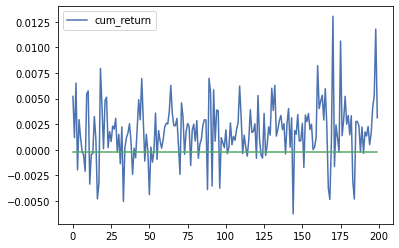

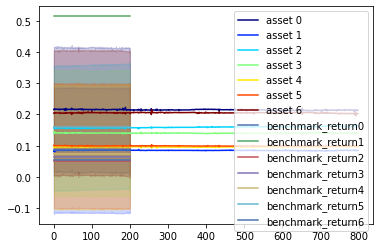

 40%|███████████████████████████████▌                                               | 399/1000 [00:15<00:20, 29.31it/s]

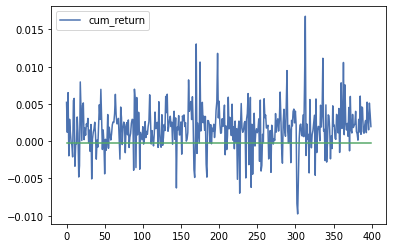

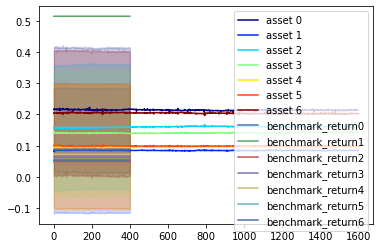

 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:23<00:21, 18.49it/s]

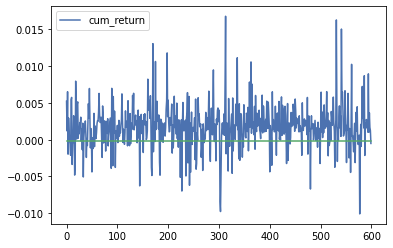

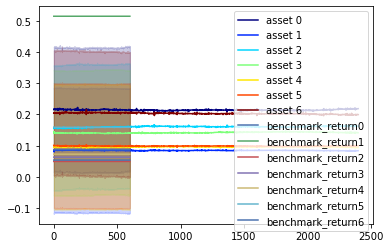

 80%|███████████████████████████████████████████████████████████████                | 798/1000 [00:31<00:07, 28.07it/s]

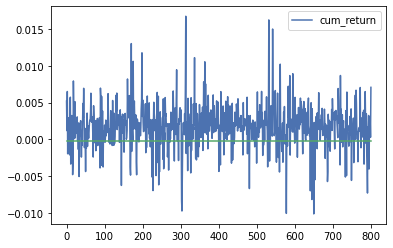

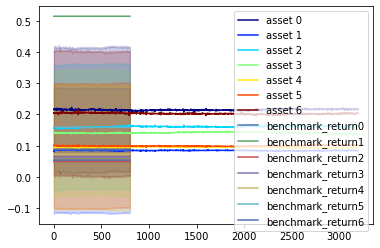

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:40<00:00, 28.11it/s]

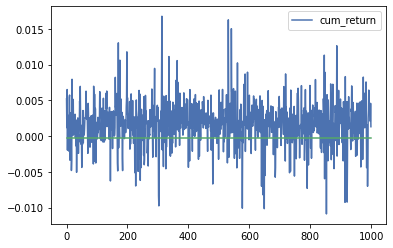

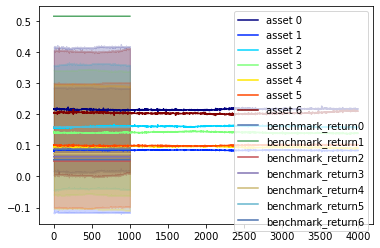

[]

In [5]:
# linear_agent.REINFORCE_fit()
max_iter = 1000

linear_agent.REINFORCE_fit(max_iterations=max_iter, add_baseline=False)

In [6]:
env.state.weight_buffer.iloc[-1]
# linear_agent.benchmark_weights

EEMV.parquet_forward_return_1_day,_0:00:00    0.096552
HYG.parquet_forward_return_1_day,_0:00:00     0.103654
MTUM.parquet_forward_return_1_day,_0:00:00    0.234059
QUAL.parquet_forward_return_1_day,_0:00:00    0.116152
SIZE.parquet_forward_return_1_day,_0:00:00    0.181544
USMV.parquet_forward_return_1_day,_0:00:00    0.095836
VLUE.parquet_forward_return_1_day,_0:00:00    0.172202
Name: 2019-06-03 04:00:00+00:00, dtype: float64

In [7]:
# save weights from model run

reinforce_train_weights = env.state.weight_buffer.iloc[-1]
reinforce_train_weights.to_csv('temp_persisted_data/reinforce_train_weights.csv')



In [8]:
def linear_agent_test(train_weights):
    weights_test = train_weights

    x_test=np.array(list(weights_test)).reshape(-1,1)
    p_vol_test=np.sqrt(np.matmul(np.matmul(x_test.T,cov),x_test))
    p_sharpe_test=np.matmul(x_test.T,mus)/p_vol_test
    linear_agent_test=LinearAgent(environment=env_test,out_reward_window_td=out_reward_window,
                             reward_function="cum_return",sample_observations=32)
    linear_agent_test.set_plot_weights(weights=np.array(list(weights_test)),
                                  benchmark_G=-p_vol_test.ravel()[0])
    return linear_agent_test


pre-sampling indices:  14%|███████▋                                                 | 432/3188 [00:07<00:54, 50.72it/s]


pre-sampling indices:  28%|████████████████▏                                        | 906/3188 [00:15<00:51, 44.41it/s]


pre-sampling indices:  43%|████████████████████████                                | 1367/3188 [00:22<00:27, 67.29it/s]


pre-sampling indices:  59%|████████████████████████████████▉                       | 1877/3188 [00:29<00:19, 68.01it/s]


pre-sampling indices:  75%|█████████████████████████████████████████▊              | 2381/3188 [00:37<00:18, 44.65it/s]


pre-sampling indices:  89%|█████████████████████████████████████████████████▋      | 2827/3188 [00:44<00:05, 67.72it/s]


pre-sampling indices: 100%|████████████████████████████████████████████████████████| 3188/3188 [00:49<00:00, 63.91it/s]


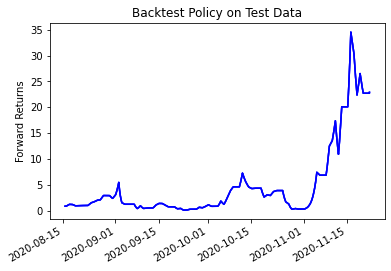

In [9]:
linear_agent_reinforce = linear_agent_test(reinforce_train_weights)

backtest_reinforce = plot_backtest(linear_agent_reinforce)
backtest_reinforce.to_csv('temp_persisted_data/backtest_reinforce.csv')


 17%|█████████████▎                                                                 | 169/1000 [00:08<00:38, 21.42it/s]


 20%|███████████████▋                                                               | 199/1000 [00:09<00:39, 20.39it/s]

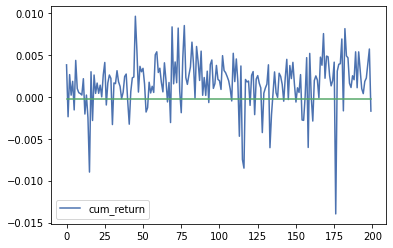

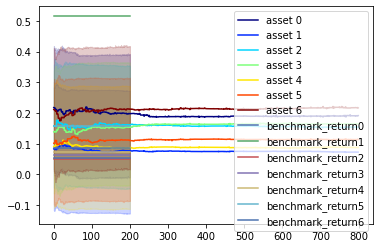


 38%|█████████████████████████████▊                                                 | 378/1000 [00:19<00:26, 23.37it/s]


 40%|███████████████████████████████▌                                               | 399/1000 [00:20<00:25, 23.80it/s]

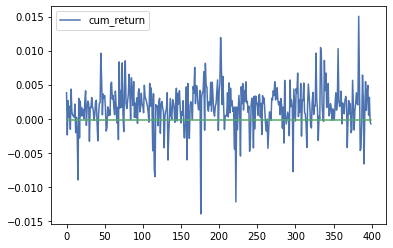

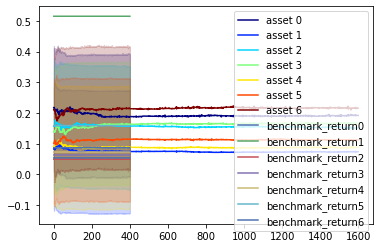


 56%|███████████████████████████████████████████▉                                   | 556/1000 [00:30<00:30, 14.47it/s]


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:32<00:20, 19.58it/s]

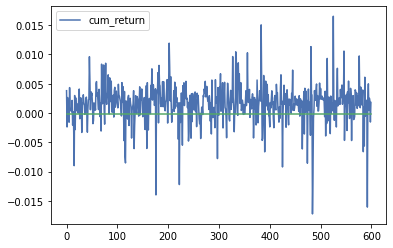

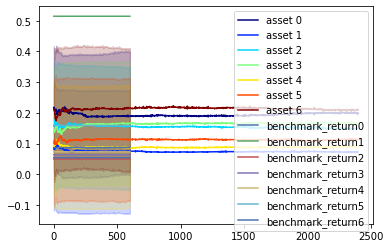


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [00:42<00:16, 13.23it/s]


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [00:42<00:13, 14.67it/s]

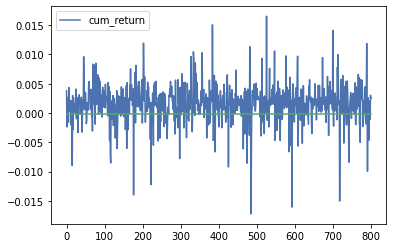

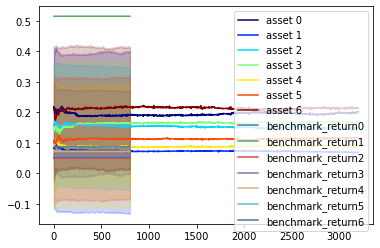


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [00:53<00:01, 19.02it/s]


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:55<00:00, 21.01it/s]

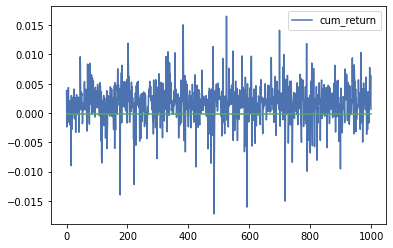

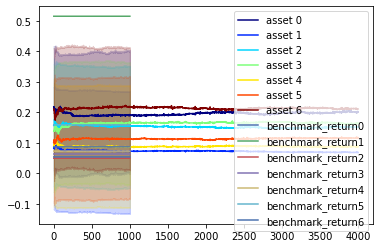



pre-sampling indices:   0%|                                                                   | 0/3188 [00:00<?, ?it/s]

pre-sampling indices:   0%|                                                           | 4/3188 [00:00<01:29, 35.71it/s]

pre-sampling indices:   0%|▏                                                          | 8/3188 [00:00<01:29, 35.71it/s]

pre-sampling indices:   0%|▏                                                         | 12/3188 [00:00<01:28, 35.85it/s]

pre-sampling indices:   1%|▎                                                         | 16/3188 [00:00<01:27, 36.20it/s]

pre-sampling indices:   1%|▎                                                         | 20/3188 [00:00<01:26, 36.49it/s]

pre-sampling indices:   1%|▍                                                         | 24/3188 [00:00<01:28, 35.67it/s]

pre-sampling indices:   1%|▌                                                         | 28/3188 [00:00<01:28, 35.78it/s]

pre-sampling indices:   1%|▌  

pre-sampling indices:   8%|████▊                                                    | 270/3188 [00:07<01:16, 38.20it/s]

pre-sampling indices:   9%|████▉                                                    | 274/3188 [00:07<01:17, 37.52it/s]

pre-sampling indices:   9%|████▉                                                    | 278/3188 [00:07<01:16, 38.23it/s]

pre-sampling indices:   9%|█████                                                    | 282/3188 [00:07<01:15, 38.24it/s]

pre-sampling indices:   9%|█████                                                    | 286/3188 [00:07<01:15, 38.64it/s]

pre-sampling indices:   9%|█████▏                                                   | 290/3188 [00:08<01:15, 38.59it/s]

pre-sampling indices:   9%|█████▎                                                   | 294/3188 [00:08<01:15, 38.44it/s]

pre-sampling indices:   9%|█████▎                                                   | 298/3188 [00:08<01:17, 37.47it/s]

pre-sampling indices:   9%|█████

pre-sampling indices:  21%|███████████▉                                             | 665/3188 [00:14<00:42, 58.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 21.01it/s]

pre-sampling indices:  21%|████████████▏                                            | 679/3188 [00:14<00:40, 61.96it/s]

pre-sampling indices:  22%|████████████▎                                            | 686/3188 [00:14<00:39, 63.65it/s]

pre-sampling indices:  22%|████████████▍                                            | 693/3188 [00:15<00:38, 64.52it/s]

pre-sampling indices:  22%|████████████▌                                            | 701/3188 [00:15<00:37, 67.12it/s]

pre-sampling indices:  22%|████████████▋                                            | 709/3188 [00:15<00:36, 68.36it/s]

pre-sampling indices:  22%|████████████▊                                            | 716/3188 [00:15<00:37, 66.75it/s]

pre-sampling indices:  23%|█████

pre-sampling indices:  36%|████████████████████                                    | 1143/3188 [00:21<00:30, 68.05it/s]

pre-sampling indices:  36%|████████████████████▏                                   | 1150/3188 [00:21<00:31, 65.54it/s]

pre-sampling indices:  36%|████████████████████▎                                   | 1158/3188 [00:21<00:29, 68.58it/s]

pre-sampling indices:  37%|████████████████████▍                                   | 1166/3188 [00:21<00:28, 71.27it/s]

pre-sampling indices:  37%|████████████████████▌                                   | 1174/3188 [00:22<00:28, 70.75it/s]

pre-sampling indices:  37%|████████████████████▊                                   | 1182/3188 [00:22<00:27, 73.27it/s]

pre-sampling indices:  37%|████████████████████▉                                   | 1190/3188 [00:22<00:27, 71.92it/s]

pre-sampling indices:  38%|█████████████████████                                   | 1198/3188 [00:22<00:27, 72.16it/s]

pre-sampling indices:  38%|█████

pre-sampling indices:  50%|████████████████████████████▏                           | 1606/3188 [00:28<00:24, 63.92it/s]

pre-sampling indices:  51%|████████████████████████████▎                           | 1614/3188 [00:28<00:23, 66.01it/s]

pre-sampling indices:  51%|████████████████████████████▍                           | 1621/3188 [00:29<00:24, 63.85it/s]

pre-sampling indices:  51%|████████████████████████████▌                           | 1628/3188 [00:29<00:24, 62.84it/s]

pre-sampling indices:  51%|████████████████████████████▋                           | 1635/3188 [00:29<00:26, 58.49it/s]

pre-sampling indices:  52%|████████████████████████████▊                           | 1642/3188 [00:29<00:25, 60.10it/s]

pre-sampling indices:  52%|████████████████████████████▉                           | 1650/3188 [00:29<00:24, 64.05it/s]

pre-sampling indices:  52%|█████████████████████████████                           | 1658/3188 [00:29<00:23, 65.93it/s]

pre-sampling indices:  52%|█████

pre-sampling indices:  66%|████████████████████████████████████▉                   | 2104/3188 [00:35<00:14, 72.36it/s]

pre-sampling indices:  66%|█████████████████████████████████████                   | 2112/3188 [00:36<00:14, 71.97it/s]

pre-sampling indices:  66%|█████████████████████████████████████▏                  | 2120/3188 [00:36<00:15, 68.14it/s]

pre-sampling indices:  67%|█████████████████████████████████████▎                  | 2127/3188 [00:36<00:16, 64.87it/s]

pre-sampling indices:  67%|█████████████████████████████████████▍                  | 2134/3188 [00:36<00:15, 66.14it/s]

pre-sampling indices:  67%|█████████████████████████████████████▌                  | 2141/3188 [00:36<00:15, 66.87it/s]

pre-sampling indices:  67%|█████████████████████████████████████▋                  | 2148/3188 [00:36<00:15, 67.77it/s]

pre-sampling indices:  68%|█████████████████████████████████████▊                  | 2155/3188 [00:36<00:15, 66.85it/s]

pre-sampling indices:  68%|█████

pre-sampling indices:  78%|███████████████████████████████████████████▊            | 2494/3188 [00:44<00:30, 22.84it/s]

pre-sampling indices:  78%|███████████████████████████████████████████▊            | 2497/3188 [00:44<00:29, 23.03it/s]

pre-sampling indices:  78%|███████████████████████████████████████████▉            | 2500/3188 [00:44<00:31, 21.83it/s]

pre-sampling indices:  79%|███████████████████████████████████████████▉            | 2503/3188 [00:44<00:31, 21.92it/s]

pre-sampling indices:  79%|████████████████████████████████████████████            | 2506/3188 [00:44<00:31, 21.86it/s]

pre-sampling indices:  79%|████████████████████████████████████████████            | 2509/3188 [00:44<00:29, 23.33it/s]

pre-sampling indices:  79%|████████████████████████████████████████████▏           | 2513/3188 [00:44<00:26, 25.73it/s]

pre-sampling indices:  79%|████████████████████████████████████████████▏           | 2517/3188 [00:44<00:24, 27.65it/s]

pre-sampling indices:  79%|█████

pre-sampling indices:  85%|███████████████████████████████████████████████▍        | 2704/3188 [00:52<00:15, 31.61it/s]

pre-sampling indices:  85%|███████████████████████████████████████████████▌        | 2709/3188 [00:52<00:14, 33.73it/s]

pre-sampling indices:  85%|███████████████████████████████████████████████▋        | 2713/3188 [00:52<00:15, 29.98it/s]

pre-sampling indices:  85%|███████████████████████████████████████████████▋        | 2717/3188 [00:53<00:16, 28.41it/s]

pre-sampling indices:  85%|███████████████████████████████████████████████▊        | 2720/3188 [00:53<00:18, 25.82it/s]

pre-sampling indices:  85%|███████████████████████████████████████████████▊        | 2723/3188 [00:53<00:20, 22.41it/s]

pre-sampling indices:  86%|███████████████████████████████████████████████▉        | 2727/3188 [00:53<00:18, 24.72it/s]

pre-sampling indices:  86%|███████████████████████████████████████████████▉        | 2730/3188 [00:53<00:17, 25.83it/s]

pre-sampling indices:  86%|█████

pre-sampling indices:  94%|████████████████████████████████████████████████████▊   | 3007/3188 [01:00<00:02, 60.82it/s]

pre-sampling indices:  95%|████████████████████████████████████████████████████▉   | 3015/3188 [01:00<00:02, 63.80it/s]

pre-sampling indices:  95%|█████████████████████████████████████████████████████   | 3022/3188 [01:00<00:02, 64.64it/s]

pre-sampling indices:  95%|█████████████████████████████████████████████████████▏  | 3029/3188 [01:00<00:02, 59.87it/s]

pre-sampling indices:  95%|█████████████████████████████████████████████████████▎  | 3036/3188 [01:00<00:02, 56.38it/s]

pre-sampling indices:  95%|█████████████████████████████████████████████████████▍  | 3043/3188 [01:00<00:02, 58.23it/s]

pre-sampling indices:  96%|█████████████████████████████████████████████████████▌  | 3049/3188 [01:01<00:02, 52.30it/s]

pre-sampling indices:  96%|█████████████████████████████████████████████████████▋  | 3055/3188 [01:01<00:02, 51.59it/s]

pre-sampling indices:  96%|█████

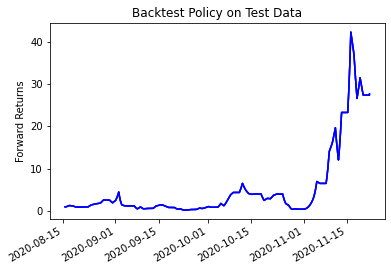

In [10]:
linear_agent.REINFORCE_fit(max_iterations=max_iter, add_baseline=True)

reinforce_baseline_train_weights = env.state.weight_buffer.iloc[-1]
reinforce_baseline_train_weights.to_csv('temp_persisted_data/reinforce_baseline_train_weights.csv')

linear_agent_reinforce_baseline = linear_agent_test(reinforce_baseline_train_weights)

backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline)
backtest_reinforce_baseline.to_csv('temp_persisted_data/backtest_reinforce_baseline.csv')



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

  0%|▏                                                                                | 2/1000 [00:00<00:53, 18.69it/s]

  0%|▎                                                                                | 4/1000 [00:00<00:52, 18.85it/s]

  1%|▍                                                                                | 6/1000 [00:00<00:53, 18.74it/s]

  1%|▋                                                                                | 8/1000 [00:00<00:53, 18.49it/s]

  1%|▊                                                                               | 10/1000 [00:00<00:53, 18.60it/s]

  1%|▉                                                                               | 12/1000 [00:00<00:56, 17.64it/s]

  1%|█                                                                               | 14/1000 [00:00<00:55, 17.66it/s]

  2%|█▎                       

 15%|███████████▊                                                                   | 150/1000 [00:08<00:39, 21.42it/s]

 15%|████████████                                                                   | 153/1000 [00:08<00:39, 21.37it/s]

 16%|████████████▎                                                                  | 156/1000 [00:08<00:39, 21.13it/s]

 16%|████████████▌                                                                  | 159/1000 [00:08<00:40, 20.99it/s]

 16%|████████████▊                                                                  | 162/1000 [00:09<00:40, 20.47it/s]

 16%|█████████████                                                                  | 165/1000 [00:09<00:40, 20.62it/s]

 17%|█████████████▎                                                                 | 168/1000 [00:09<00:39, 20.81it/s]

 17%|█████████████▌                                                                 | 171/1000 [00:09<00:39, 21.17it/s]

 17%|█████████████▋             

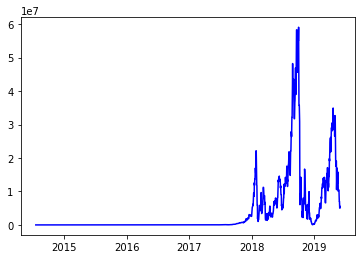

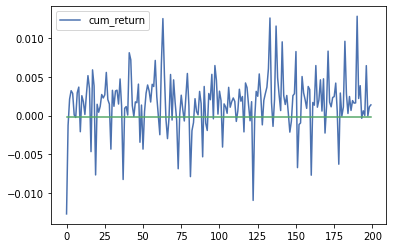

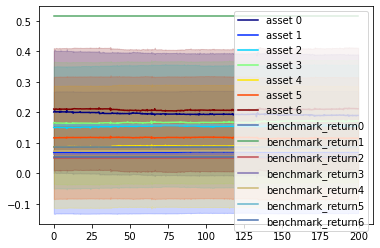

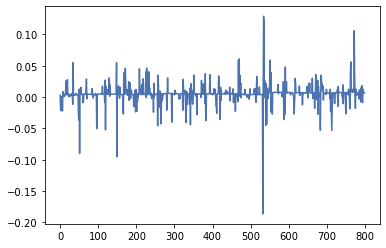



 20%|███████████████▉                                                               | 201/1000 [00:15<06:36,  2.01it/s]

 20%|████████████████                                                               | 204/1000 [00:15<04:46,  2.77it/s]

 21%|████████████████▎                                                              | 207/1000 [00:15<03:31,  3.75it/s]

 21%|████████████████▌                                                              | 209/1000 [00:15<02:40,  4.94it/s]

 21%|████████████████▋                                                              | 211/1000 [00:15<02:04,  6.31it/s]

 21%|████████████████▊                                                              | 213/1000 [00:15<01:40,  7.85it/s]

 22%|████████████████▉                                                              | 215/1000 [00:16<01:21,  9.60it/s]

 22%|█████████████████▏                                                             | 217/1000 [00:16<01:12, 10.86it/s]

 22%|█████████████████▎       

 36%|████████████████████████████                                                   | 356/1000 [00:24<00:30, 21.14it/s]

 36%|████████████████████████████▎                                                  | 359/1000 [00:24<00:29, 21.41it/s]

 36%|████████████████████████████▌                                                  | 362/1000 [00:24<00:29, 21.74it/s]

 36%|████████████████████████████▊                                                  | 365/1000 [00:24<00:29, 21.58it/s]

 37%|█████████████████████████████                                                  | 368/1000 [00:24<00:30, 20.60it/s]

 37%|█████████████████████████████▎                                                 | 371/1000 [00:25<00:30, 20.62it/s]

 37%|█████████████████████████████▌                                                 | 374/1000 [00:25<00:30, 20.49it/s]

 38%|█████████████████████████████▊                                                 | 377/1000 [00:25<00:30, 20.22it/s]

 38%|███████████████████████████

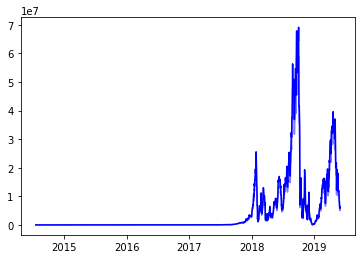

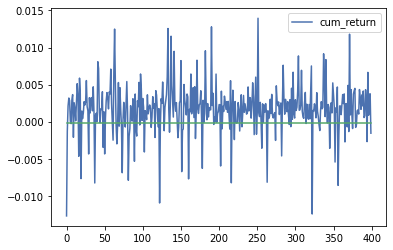

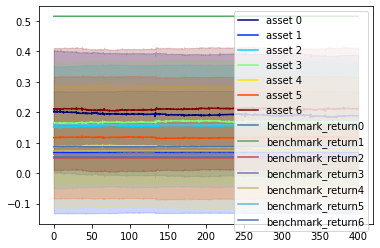

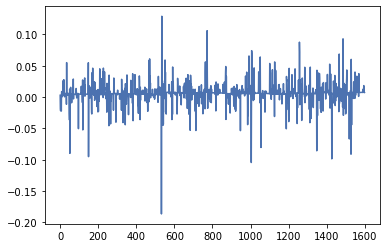



 40%|███████████████████████████████▋                                               | 401/1000 [00:30<04:51,  2.06it/s]

 40%|███████████████████████████████▊                                               | 403/1000 [00:30<03:32,  2.81it/s]

 40%|███████████████████████████████▉                                               | 405/1000 [00:31<02:37,  3.78it/s]

 41%|████████████████████████████████▏                                              | 407/1000 [00:31<02:00,  4.91it/s]

 41%|████████████████████████████████▎                                              | 409/1000 [00:31<01:33,  6.33it/s]

 41%|████████████████████████████████▌                                              | 412/1000 [00:31<01:13,  8.03it/s]

 41%|████████████████████████████████▋                                              | 414/1000 [00:31<01:00,  9.76it/s]

 42%|████████████████████████████████▊                                              | 416/1000 [00:31<00:51, 11.25it/s]

 42%|█████████████████████████

 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:40<00:40, 11.59it/s]

 53%|██████████████████████████████████████████                                     | 532/1000 [00:40<00:48,  9.70it/s]

 53%|██████████████████████████████████████████▏                                    | 534/1000 [00:40<00:46, 10.06it/s]

 54%|██████████████████████████████████████████▎                                    | 536/1000 [00:40<00:42, 11.04it/s]

 54%|██████████████████████████████████████████▌                                    | 538/1000 [00:40<00:37, 12.44it/s]

 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:40<00:33, 13.67it/s]

 54%|██████████████████████████████████████████▊                                    | 542/1000 [00:41<00:30, 14.82it/s]

 55%|███████████████████████████████████████████                                    | 545/1000 [00:41<00:28, 16.09it/s]

 55%|███████████████████████████

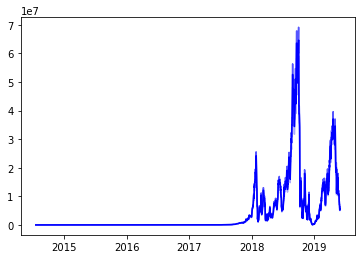

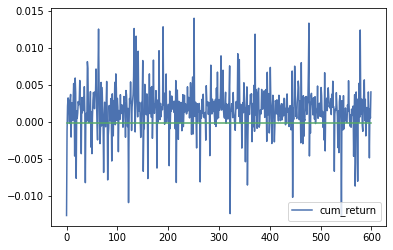

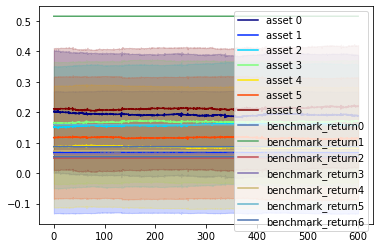

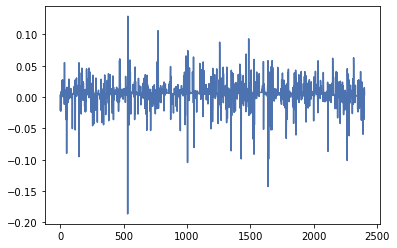



 60%|███████████████████████████████████████████████▌                               | 602/1000 [00:48<04:04,  1.63it/s]

 60%|███████████████████████████████████████████████▊                               | 605/1000 [00:48<02:54,  2.26it/s]

 61%|████████████████████████████████████████████████                               | 608/1000 [00:49<02:06,  3.09it/s]

 61%|████████████████████████████████████████████████▎                              | 611/1000 [00:49<01:33,  4.17it/s]

 61%|████████████████████████████████████████████████▍                              | 613/1000 [00:49<01:11,  5.44it/s]

 62%|████████████████████████████████████████████████▌                              | 615/1000 [00:49<00:57,  6.70it/s]

 62%|████████████████████████████████████████████████▋                              | 617/1000 [00:49<00:46,  8.16it/s]

 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:49<00:37, 10.06it/s]

 62%|█████████████████████████

 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [00:57<00:09, 22.37it/s]

 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [00:57<00:09, 21.86it/s]

 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [00:57<00:09, 22.16it/s]

 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [00:57<00:09, 22.03it/s]

 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [00:58<00:09, 21.11it/s]

 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [00:58<00:09, 21.66it/s]

 80%|███████████████████████████████████████████████████████████████                | 798/1000 [00:58<00:09, 22.17it/s]

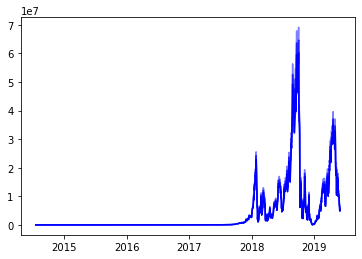

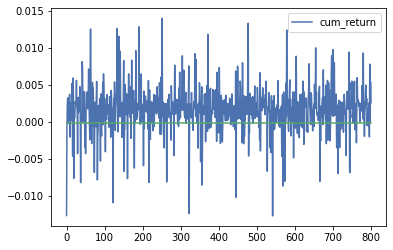

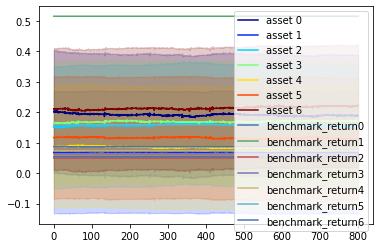

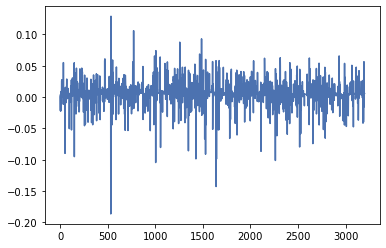



 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [01:02<01:28,  2.25it/s]

 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [01:02<01:03,  3.08it/s]

 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [01:02<00:46,  4.16it/s]

 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [01:02<00:35,  5.43it/s]

 81%|████████████████████████████████████████████████████████████████               | 811/1000 [01:02<00:27,  6.90it/s]

 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [01:03<00:21,  8.69it/s]

 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [01:03<00:17, 10.67it/s]

 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [01:03<00:14, 12.74it/s]

 82%|█████████████████████████

 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [01:11<00:00, 22.22it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [01:11<00:00, 22.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [01:11<00:00, 21.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:11<00:00, 21.34it/s]

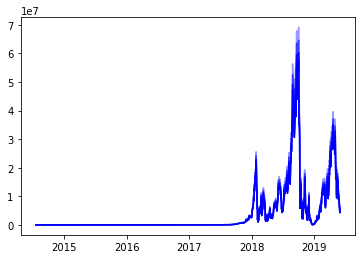

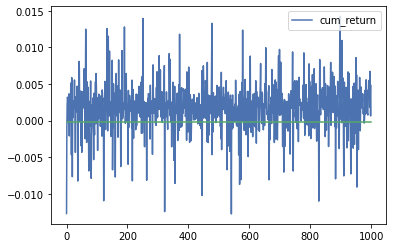

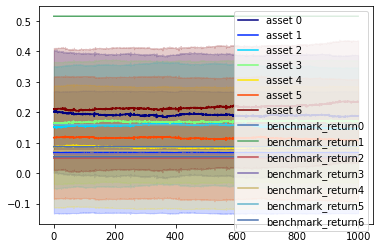

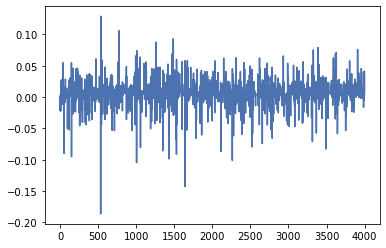




pre-sampling indices:   0%|                                                                   | 0/3188 [00:00<?, ?it/s]


pre-sampling indices:   0%|▏                                                          | 8/3188 [00:00<00:40, 77.67it/s]


pre-sampling indices:   1%|▎                                                         | 16/3188 [00:00<00:40, 77.45it/s]


pre-sampling indices:   1%|▍                                                         | 24/3188 [00:00<00:41, 76.84it/s]


pre-sampling indices:   1%|▌                                                         | 32/3188 [00:00<00:40, 77.76it/s]


pre-sampling indices:   1%|▋                                                         | 40/3188 [00:00<00:40, 77.06it/s]


pre-sampling indices:   1%|▊                                                         | 47/3188 [00:00<00:42, 73.16it/s]


pre-sampling indices:   2%|▉                                                         | 54/3188 [00:00<00:45, 69.39it/s]


pre-sampling indices:

pre-sampling indices:  15%|████████▎                                                | 464/3188 [00:07<00:39, 69.59it/s]


pre-sampling indices:  15%|████████▍                                                | 472/3188 [00:07<00:37, 71.83it/s]


pre-sampling indices:  15%|████████▌                                                | 480/3188 [00:07<00:36, 73.29it/s]


pre-sampling indices:  15%|████████▋                                                | 488/3188 [00:07<00:36, 73.49it/s]


pre-sampling indices:  16%|████████▊                                                | 496/3188 [00:07<00:36, 73.46it/s]


pre-sampling indices:  16%|█████████                                                | 504/3188 [00:07<00:37, 72.05it/s]


pre-sampling indices:  16%|█████████▏                                               | 512/3188 [00:07<00:36, 73.64it/s]


pre-sampling indices:  16%|█████████▎                                               | 521/3188 [00:07<00:35, 76.11it/s]


pre-sampling indices:  1

pre-sampling indices:  30%|█████████████████                                        | 956/3188 [00:14<00:29, 75.25it/s]


pre-sampling indices:  30%|█████████████████▏                                       | 964/3188 [00:14<00:32, 69.25it/s]


pre-sampling indices:  30%|█████████████████▍                                       | 972/3188 [00:14<00:32, 67.59it/s]


pre-sampling indices:  31%|█████████████████▌                                       | 980/3188 [00:14<00:31, 69.31it/s]


pre-sampling indices:  31%|█████████████████▋                                       | 988/3188 [00:14<00:30, 71.05it/s]


pre-sampling indices:  31%|█████████████████▊                                       | 996/3188 [00:14<00:30, 71.55it/s]


pre-sampling indices:  31%|█████████████████▋                                      | 1004/3188 [00:14<00:29, 73.28it/s]


pre-sampling indices:  32%|█████████████████▊                                      | 1012/3188 [00:14<00:29, 73.71it/s]


pre-sampling indices:  3

pre-sampling indices:  45%|█████████████████████████▎                              | 1443/3188 [00:20<00:24, 70.77it/s]


pre-sampling indices:  46%|█████████████████████████▍                              | 1451/3188 [00:20<00:24, 69.67it/s]


pre-sampling indices:  46%|█████████████████████████▋                              | 1459/3188 [00:21<00:24, 71.51it/s]


pre-sampling indices:  46%|█████████████████████████▊                              | 1467/3188 [00:21<00:23, 73.45it/s]


pre-sampling indices:  46%|█████████████████████████▉                              | 1475/3188 [00:21<00:24, 69.19it/s]


pre-sampling indices:  47%|██████████████████████████                              | 1483/3188 [00:21<00:24, 69.66it/s]


pre-sampling indices:  47%|██████████████████████████▏                             | 1491/3188 [00:21<00:25, 66.42it/s]


pre-sampling indices:  47%|██████████████████████████▎                             | 1499/3188 [00:21<00:24, 68.90it/s]


pre-sampling indices:  4

pre-sampling indices:  60%|█████████████████████████████████▋                      | 1920/3188 [00:27<00:23, 55.11it/s]


pre-sampling indices:  60%|█████████████████████████████████▊                      | 1926/3188 [00:27<00:22, 54.94it/s]


pre-sampling indices:  61%|█████████████████████████████████▉                      | 1932/3188 [00:28<00:23, 54.14it/s]


pre-sampling indices:  61%|██████████████████████████████████                      | 1939/3188 [00:28<00:21, 57.24it/s]


pre-sampling indices:  61%|██████████████████████████████████▏                     | 1945/3188 [00:28<00:22, 56.40it/s]


pre-sampling indices:  61%|██████████████████████████████████▎                     | 1951/3188 [00:28<00:23, 52.67it/s]


pre-sampling indices:  61%|██████████████████████████████████▍                     | 1957/3188 [00:28<00:23, 52.58it/s]


pre-sampling indices:  62%|██████████████████████████████████▍                     | 1963/3188 [00:28<00:25, 48.39it/s]


pre-sampling indices:  6

pre-sampling indices:  75%|██████████████████████████████████████████              | 2391/3188 [00:34<00:11, 72.26it/s]


pre-sampling indices:  75%|██████████████████████████████████████████▏             | 2399/3188 [00:34<00:11, 71.43it/s]


pre-sampling indices:  76%|██████████████████████████████████████████▎             | 2408/3188 [00:35<00:10, 73.71it/s]


pre-sampling indices:  76%|██████████████████████████████████████████▍             | 2416/3188 [00:35<00:10, 75.05it/s]


pre-sampling indices:  76%|██████████████████████████████████████████▌             | 2424/3188 [00:35<00:10, 76.36it/s]


pre-sampling indices:  76%|██████████████████████████████████████████▋             | 2433/3188 [00:35<00:09, 78.10it/s]


pre-sampling indices:  77%|██████████████████████████████████████████▉             | 2441/3188 [00:35<00:09, 78.19it/s]


pre-sampling indices:  77%|███████████████████████████████████████████             | 2450/3188 [00:35<00:09, 79.04it/s]


pre-sampling indices:  7

pre-sampling indices:  91%|██████████████████████████████████████████████████▊     | 2890/3188 [00:41<00:04, 74.34it/s]


pre-sampling indices:  91%|██████████████████████████████████████████████████▉     | 2898/3188 [00:41<00:04, 70.27it/s]


pre-sampling indices:  91%|███████████████████████████████████████████████████     | 2906/3188 [00:41<00:04, 69.59it/s]


pre-sampling indices:  91%|███████████████████████████████████████████████████▏    | 2914/3188 [00:41<00:03, 70.50it/s]


pre-sampling indices:  92%|███████████████████████████████████████████████████▎    | 2922/3188 [00:42<00:03, 70.48it/s]


pre-sampling indices:  92%|███████████████████████████████████████████████████▍    | 2930/3188 [00:42<00:03, 72.50it/s]


pre-sampling indices:  92%|███████████████████████████████████████████████████▌    | 2938/3188 [00:42<00:03, 73.46it/s]


pre-sampling indices:  92%|███████████████████████████████████████████████████▋    | 2946/3188 [00:42<00:03, 74.89it/s]


pre-sampling indices:  9

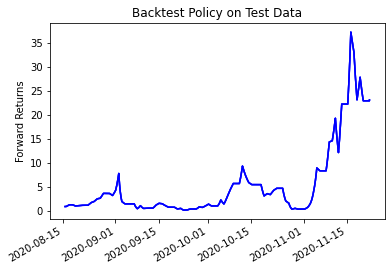

In [11]:
linear_agent.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter)

actor_critic_trace_train_weights = env.state.weight_buffer.iloc[-1]
actor_critic_trace_train_weights.to_csv('temp_persisted_data/actor_critic_trace_train_weights.csv')

linear_agent_actor_critic_trace = linear_agent_test(actor_critic_trace_train_weights)

backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace)
backtest_actor_critic_trace.to_csv('temp_persisted_data/backtest_actor_critic_trace.csv')




  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


  0%|▏                                                                                | 2/1000 [00:00<01:13, 13.61it/s]


  0%|▎                                                                                | 4/1000 [00:00<01:13, 13.47it/s]


  1%|▍                                                                                | 6/1000 [00:00<01:21, 12.26it/s]


  1%|▌                                                                                | 7/1000 [00:00<01:29, 11.14it/s]


  1%|▋                                                                                | 9/1000 [00:00<01:26, 11.46it/s]


  1%|▉                                                                               | 11/1000 [00:00<01:19, 12.43it/s]


  1%|█                                                                               | 13/1000 [00:01<01:14, 13.29it/s]


  2%|█▏              

 15%|███████████▌                                                                   | 147/1000 [00:08<00:57, 14.78it/s]


 15%|███████████▊                                                                   | 149/1000 [00:08<00:56, 15.04it/s]


 15%|███████████▉                                                                   | 151/1000 [00:08<00:52, 16.17it/s]


 15%|████████████                                                                   | 153/1000 [00:08<00:49, 17.00it/s]


 16%|████████████▏                                                                  | 155/1000 [00:08<00:48, 17.34it/s]


 16%|████████████▍                                                                  | 158/1000 [00:09<00:44, 18.81it/s]


 16%|████████████▋                                                                  | 161/1000 [00:09<00:42, 19.60it/s]


 16%|████████████▉                                                                  | 164/1000 [00:09<00:41, 20.36it/s]


 17%|█████████████▏     

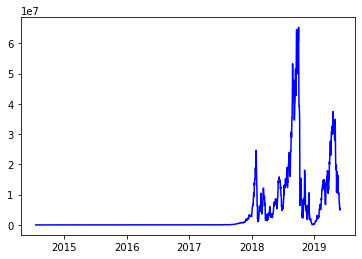

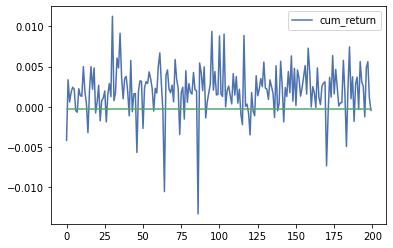

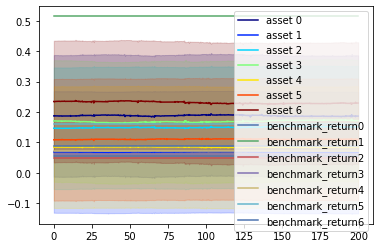

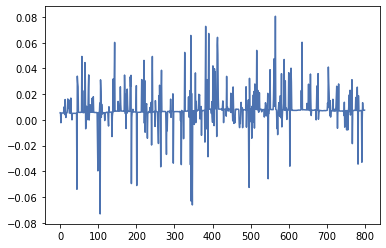




 20%|████████████████                                                               | 203/1000 [00:15<05:51,  2.27it/s]


 21%|████████████████▎                                                              | 206/1000 [00:15<04:15,  3.11it/s]


 21%|████████████████▌                                                              | 209/1000 [00:15<03:08,  4.20it/s]


 21%|████████████████▋                                                              | 211/1000 [00:15<02:23,  5.50it/s]


 21%|████████████████▉                                                              | 214/1000 [00:15<01:50,  7.13it/s]


 22%|█████████████████▏                                                             | 217/1000 [00:15<01:27,  8.99it/s]


 22%|█████████████████▍                                                             | 220/1000 [00:15<01:11, 10.88it/s]


 22%|█████████████████▌                                                             | 223/1000 [00:16<01:00, 12.88it/s]


 23%|████████████████

 38%|██████████████████████████████▎                                                | 384/1000 [00:23<00:28, 21.67it/s]


 39%|██████████████████████████████▌                                                | 387/1000 [00:23<00:28, 21.83it/s]


 39%|██████████████████████████████▊                                                | 390/1000 [00:23<00:28, 21.54it/s]


 39%|███████████████████████████████                                                | 393/1000 [00:24<00:29, 20.85it/s]


 40%|███████████████████████████████▎                                               | 396/1000 [00:24<00:27, 21.61it/s]


 40%|███████████████████████████████▌                                               | 399/1000 [00:24<00:27, 21.79it/s]

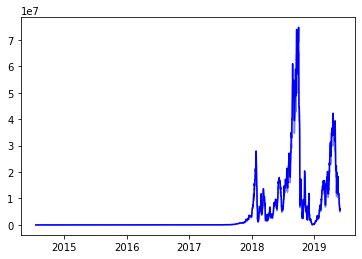

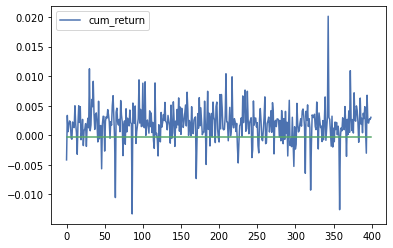

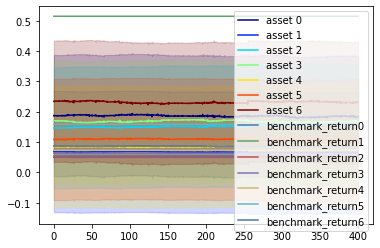

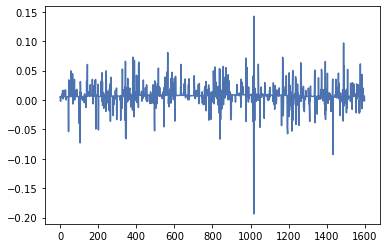




 40%|███████████████████████████████▊                                               | 402/1000 [00:28<04:22,  2.28it/s]


 40%|███████████████████████████████▉                                               | 405/1000 [00:28<03:09,  3.13it/s]


 41%|████████████████████████████████▏                                              | 408/1000 [00:28<02:20,  4.21it/s]


 41%|████████████████████████████████▍                                              | 411/1000 [00:28<01:45,  5.59it/s]


 41%|████████████████████████████████▋                                              | 414/1000 [00:28<01:21,  7.16it/s]


 42%|████████████████████████████████▉                                              | 417/1000 [00:29<01:04,  9.05it/s]


 42%|█████████████████████████████████▏                                             | 420/1000 [00:29<00:52, 11.07it/s]


 42%|█████████████████████████████████▍                                             | 423/1000 [00:29<00:44, 13.07it/s]


 43%|████████████████

 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:37<00:21, 20.54it/s]


 56%|████████████████████████████████████████████▍                                  | 563/1000 [00:37<00:21, 20.29it/s]


 57%|████████████████████████████████████████████▋                                  | 566/1000 [00:37<00:20, 21.14it/s]


 57%|████████████████████████████████████████████▉                                  | 569/1000 [00:37<00:19, 21.74it/s]


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [00:37<00:19, 22.27it/s]


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [00:37<00:19, 22.01it/s]


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [00:38<00:18, 22.42it/s]


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [00:38<00:19, 22.04it/s]


 58%|███████████████████

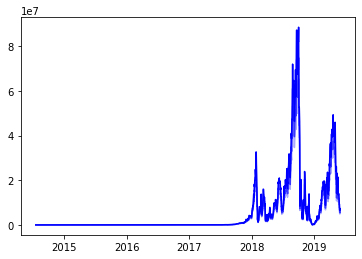

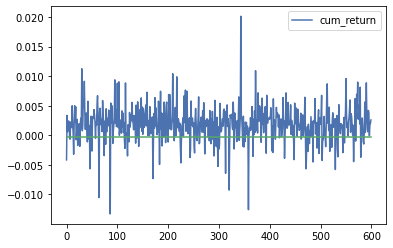

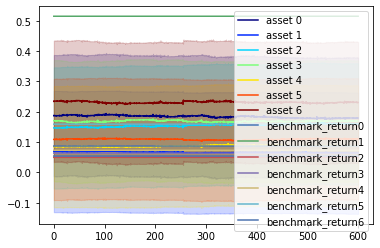

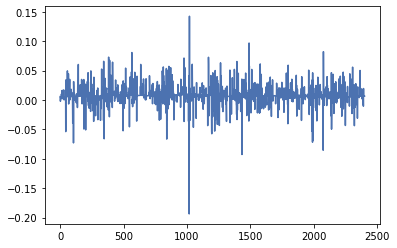




 60%|███████████████████████████████████████████████▌                               | 602/1000 [00:42<02:51,  2.32it/s]


 60%|███████████████████████████████████████████████▊                               | 605/1000 [00:43<02:03,  3.19it/s]


 61%|████████████████████████████████████████████████                               | 608/1000 [00:43<01:31,  4.30it/s]


 61%|████████████████████████████████████████████████▎                              | 611/1000 [00:43<01:08,  5.70it/s]


 61%|████████████████████████████████████████████████▌                              | 614/1000 [00:43<00:52,  7.37it/s]


 62%|████████████████████████████████████████████████▋                              | 617/1000 [00:43<00:41,  9.30it/s]


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:43<00:33, 11.28it/s]


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [00:43<00:28, 13.27it/s]


 63%|████████████████

 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [00:51<00:09, 23.06it/s]


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [00:51<00:09, 22.85it/s]


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [00:51<00:08, 23.36it/s]


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [00:51<00:08, 23.20it/s]


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [00:51<00:08, 23.94it/s]

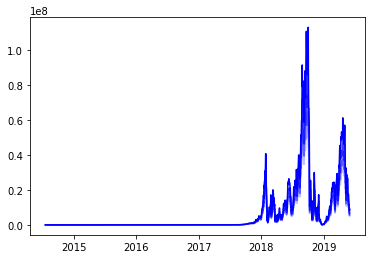

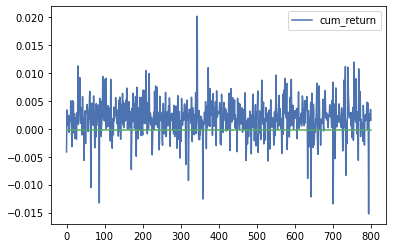

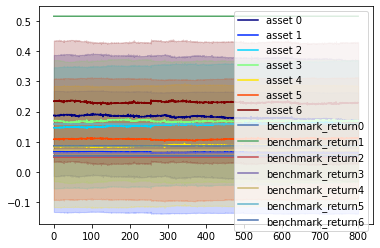

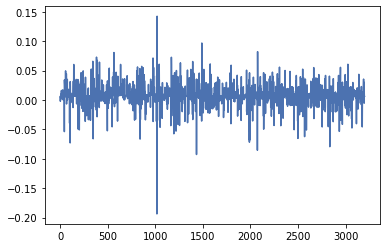




 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [00:55<01:17,  2.54it/s]


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [00:55<00:55,  3.47it/s]


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [00:55<00:40,  4.68it/s]


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [00:55<00:30,  6.16it/s]


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [00:55<00:23,  7.84it/s]


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [00:55<00:18,  9.82it/s]


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [00:55<00:15, 11.88it/s]


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [00:56<00:12, 13.95it/s]


 83%|████████████████

 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [01:03<00:00, 21.57it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [01:03<00:00, 21.03it/s]


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [01:03<00:00, 21.56it/s]


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [01:04<00:00, 20.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [01:04<00:00, 21.09it/s]


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [01:04<00:00, 21.74it/s]

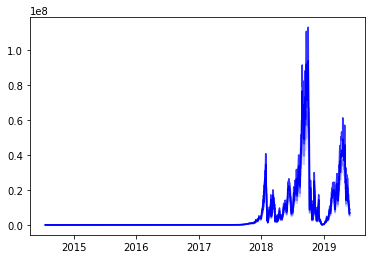

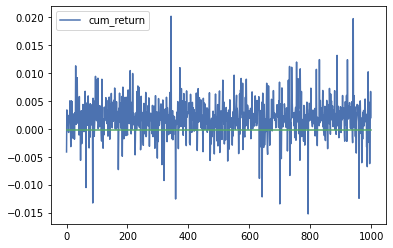

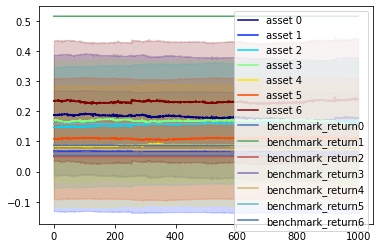

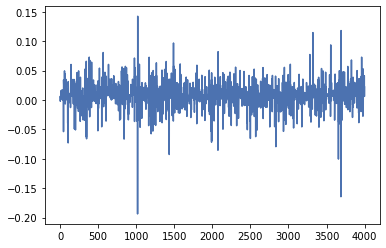





pre-sampling indices:   0%|                                                                   | 0/3188 [00:00<?, ?it/s]



pre-sampling indices:   0%|▏                                                          | 8/3188 [00:00<00:42, 75.47it/s]



pre-sampling indices:   0%|▎                                                         | 15/3188 [00:00<00:44, 71.70it/s]



pre-sampling indices:   1%|▍                                                         | 23/3188 [00:00<00:44, 71.79it/s]



pre-sampling indices:   1%|▌                                                         | 31/3188 [00:00<00:43, 72.26it/s]



pre-sampling indices:   1%|▋                                                         | 39/3188 [00:00<00:43, 72.99it/s]



pre-sampling indices:   1%|▊                                                         | 47/3188 [00:00<00:42, 73.52it/s]



pre-sampling indices:   2%|█                                                         | 55/3188 [00:00<00:41, 75.14it/s]



pre-sampling

pre-sampling indices:  13%|███████▍                                                 | 418/3188 [00:07<00:56, 49.16it/s]



pre-sampling indices:  13%|███████▌                                                 | 424/3188 [00:07<00:57, 48.32it/s]



pre-sampling indices:  14%|███████▋                                                 | 431/3188 [00:07<00:53, 51.97it/s]



pre-sampling indices:  14%|███████▊                                                 | 438/3188 [00:07<00:49, 55.78it/s]



pre-sampling indices:  14%|███████▉                                                 | 446/3188 [00:07<00:45, 59.84it/s]



pre-sampling indices:  14%|████████                                                 | 454/3188 [00:07<00:42, 63.95it/s]



pre-sampling indices:  14%|████████▏                                                | 461/3188 [00:07<00:41, 65.11it/s]



pre-sampling indices:  15%|████████▍                                                | 469/3188 [00:07<00:39, 68.08it/s]



pre-sampling ind

pre-sampling indices:  27%|███████████████▌                                         | 871/3188 [00:13<00:32, 72.00it/s]



pre-sampling indices:  28%|███████████████▋                                         | 879/3188 [00:13<00:32, 71.16it/s]



pre-sampling indices:  28%|███████████████▊                                         | 887/3188 [00:13<00:32, 70.49it/s]



pre-sampling indices:  28%|████████████████                                         | 895/3188 [00:14<00:32, 69.84it/s]



pre-sampling indices:  28%|████████████████▏                                        | 903/3188 [00:14<00:33, 69.22it/s]



pre-sampling indices:  29%|████████████████▎                                        | 910/3188 [00:14<00:33, 67.64it/s]



pre-sampling indices:  29%|████████████████▍                                        | 918/3188 [00:14<00:32, 69.27it/s]



pre-sampling indices:  29%|████████████████▌                                        | 926/3188 [00:14<00:31, 70.78it/s]



pre-sampling ind

pre-sampling indices:  40%|██████████████████████▍                                 | 1278/3188 [00:20<00:31, 60.51it/s]



pre-sampling indices:  40%|██████████████████████▌                                 | 1285/3188 [00:20<00:30, 61.90it/s]



pre-sampling indices:  41%|██████████████████████▋                                 | 1292/3188 [00:20<00:29, 63.60it/s]



pre-sampling indices:  41%|██████████████████████▊                                 | 1299/3188 [00:20<00:29, 64.85it/s]



pre-sampling indices:  41%|██████████████████████▉                                 | 1306/3188 [00:21<00:28, 65.94it/s]



pre-sampling indices:  41%|███████████████████████                                 | 1314/3188 [00:21<00:27, 67.83it/s]



pre-sampling indices:  41%|███████████████████████▏                                | 1321/3188 [00:21<00:27, 67.84it/s]



pre-sampling indices:  42%|███████████████████████▎                                | 1328/3188 [00:21<00:27, 67.29it/s]



pre-sampling ind

pre-sampling indices:  52%|█████████████████████████████▎                          | 1670/3188 [00:27<00:36, 42.05it/s]



pre-sampling indices:  53%|█████████████████████████████▍                          | 1675/3188 [00:27<00:38, 39.26it/s]



pre-sampling indices:  53%|█████████████████████████████▌                          | 1680/3188 [00:28<00:36, 40.78it/s]



pre-sampling indices:  53%|█████████████████████████████▌                          | 1685/3188 [00:28<00:36, 40.94it/s]



pre-sampling indices:  53%|█████████████████████████████▋                          | 1690/3188 [00:28<00:36, 41.46it/s]



pre-sampling indices:  53%|█████████████████████████████▊                          | 1695/3188 [00:28<00:36, 41.11it/s]



pre-sampling indices:  53%|█████████████████████████████▊                          | 1700/3188 [00:28<00:38, 38.73it/s]



pre-sampling indices:  53%|█████████████████████████████▉                          | 1704/3188 [00:28<00:38, 38.43it/s]



pre-sampling ind

pre-sampling indices:  64%|███████████████████████████████████▉                    | 2046/3188 [00:34<00:20, 55.84it/s]



pre-sampling indices:  64%|████████████████████████████████████                    | 2052/3188 [00:34<00:21, 51.85it/s]



pre-sampling indices:  65%|████████████████████████████████████▏                   | 2058/3188 [00:34<00:22, 50.69it/s]



pre-sampling indices:  65%|████████████████████████████████████▎                   | 2064/3188 [00:35<00:23, 47.54it/s]



pre-sampling indices:  65%|████████████████████████████████████▎                   | 2069/3188 [00:35<00:26, 42.63it/s]



pre-sampling indices:  65%|████████████████████████████████████▍                   | 2074/3188 [00:35<00:28, 39.43it/s]



pre-sampling indices:  65%|████████████████████████████████████▌                   | 2079/3188 [00:35<00:28, 38.54it/s]



pre-sampling indices:  65%|████████████████████████████████████▌                   | 2083/3188 [00:35<00:29, 37.65it/s]



pre-sampling ind

pre-sampling indices:  77%|███████████████████████████████████████████▏            | 2456/3188 [00:41<00:11, 64.71it/s]



pre-sampling indices:  77%|███████████████████████████████████████████▎            | 2463/3188 [00:41<00:11, 63.85it/s]



pre-sampling indices:  78%|███████████████████████████████████████████▍            | 2471/3188 [00:41<00:10, 66.40it/s]



pre-sampling indices:  78%|███████████████████████████████████████████▌            | 2479/3188 [00:41<00:10, 68.35it/s]



pre-sampling indices:  78%|███████████████████████████████████████████▋            | 2487/3188 [00:41<00:10, 69.43it/s]



pre-sampling indices:  78%|███████████████████████████████████████████▊            | 2495/3188 [00:42<00:09, 70.48it/s]



pre-sampling indices:  79%|███████████████████████████████████████████▉            | 2503/3188 [00:42<00:09, 72.88it/s]



pre-sampling indices:  79%|████████████████████████████████████████████            | 2511/3188 [00:42<00:09, 72.84it/s]



pre-sampling ind

pre-sampling indices:  91%|███████████████████████████████████████████████████▏    | 2911/3188 [00:48<00:04, 66.20it/s]



pre-sampling indices:  92%|███████████████████████████████████████████████████▎    | 2918/3188 [00:48<00:04, 66.42it/s]



pre-sampling indices:  92%|███████████████████████████████████████████████████▍    | 2925/3188 [00:48<00:03, 66.69it/s]



pre-sampling indices:  92%|███████████████████████████████████████████████████▌    | 2934/3188 [00:48<00:03, 70.27it/s]



pre-sampling indices:  92%|███████████████████████████████████████████████████▋    | 2942/3188 [00:48<00:03, 69.88it/s]



pre-sampling indices:  93%|███████████████████████████████████████████████████▊    | 2950/3188 [00:48<00:03, 68.41it/s]



pre-sampling indices:  93%|███████████████████████████████████████████████████▉    | 2957/3188 [00:48<00:03, 60.18it/s]



pre-sampling indices:  93%|████████████████████████████████████████████████████    | 2964/3188 [00:49<00:04, 48.30it/s]



pre-sampling ind

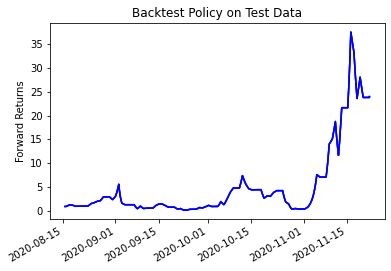

In [12]:
linear_agent.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter)

actor_critic_no_trace_train_weights = env.state.weight_buffer.iloc[-1]
actor_critic_no_trace_train_weights.to_csv('temp_persisted_data/actor_critic_no_trace_train_weights.csv')

linear_agent_actor_critic_no_trace = linear_agent_test(actor_critic_trace_train_weights)

backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace)
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/backtest_actor_critic_no_trace.csv')

In [13]:
# import importlib
# import environments
# importlib.reload(linear_agent)